# Measuring Fairness

The first step to addressing algorithmic bias is to be able to measure the degree of fairness (or lack thereof) in a given dataset. This chapter covers a number of commonly used fairness measures. For concreteness, we will demonstrate these fairness measures by calculating them on the [Compas Recidivism Dataset](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis).

```{admonition} Data: Compas Recidivism Dataset
:class: note
- Location: "data/compas-scores-two-years.csv"
- Shape: (7214, 53)
- Note: data taken from ProPublica's analyses of COMPAS
```

The following script imports the dataset and prints the first few rows.

In [2]:
# import compas two-year dataset
import pandas as pd
compas = pd.read_csv('../data/compas-scores-two-years.csv')
compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
# following the ProPublica analysis, we remove several rows with missing data
# see https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb for more details
compas = compas[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
compas = compas[(compas['days_b_screening_arrest'] <= 30) & 
                (compas['days_b_screening_arrest'] >= -30) &  
                (compas['is_recid'] != -1) &
                (compas['c_charge_degree'] != 'O') & 
                (compas['score_text'] != 'N/A')]
compas.shape

(6172, 13)

In [4]:
# finally, we focus on "race" as the protected attribute and African American vs. Caucasian as the two groups
compas = compas[compas['race'].isin(['African-American', 'Caucasian'])]
compas.shape

(5278, 13)

## Fairness Measures for Binary Classifier

To begin with, we consider measuring fairness of a classification model. In the ```Compas``` dataset, the ```score_text``` columns contains model-predicted risk level (low, medium, high) and the ```two_year_recid``` column contains the actual two-year recidivism label (1, 0). Because the ground-truth outcome label is binary, we focus on the "low" and "high" predicted classes here.[^footnote1]

In [5]:
compas_binary = compas.copy()
# remove "medium" in score_text
compas_binary = compas_binary[compas_binary['score_text'] != 'Medium']

Throughout this chapter, we adopt the following notations in formal definitions of different fairness measures:

```{admonition} Notations
:class: tip
- $Y$: actual outcome (0/1, recidivism without two years or not);
- $\widehat{Y}$: predicted risk score ("High" or "Low");
- $p$: predicted probability of being "High" risk;
- $R$: race, protected attribute of interested in this example. $R \in \{AA, W\}$ represents African American and Caucasian respectively;
- $\boldsymbol{X}$: other observable characteristics (e.g., gender, age, prior offenses).
```

### Demographic Parity

**Demographic parity** (sometimes also referred to as **Statistical Parity**) is one of the most straightforward fairness measures. It simply asserts that one group should not receive systematically more favorable predicted outcomes than the other group. Despite its simplicity, it has been extensively used / discussed in the prior literature, such as {cite:t}`calders2010three,calders2009building,kamiran2009classifying,kamishima2011fairness`, among many others.

In the context of recidivism prediction, with the protected attribute being race and the two groups to be compared being African American vs. White, demographic parity can be defined as:

```{admonition} Definition: Demographic Parity for Binary Classifier
:class: tip
$$
\Pr(\widehat{Y} = High | R = AA) = \Pr(\widehat{Y} = High | R = W)
$$
```

In [6]:
# evaluate demographic parity
# percentage of "high" scores among African Americans
AA_pct = len(compas_binary[(compas_binary['score_text'] == 'High') & (compas_binary['race'] == 'African-American')]) / len(compas_binary[compas_binary['race'] == 'African-American'])
# percentage of "high" scores among Whites
W_pct = len(compas_binary[(compas_binary['score_text'] == 'High') & (compas_binary['race'] == 'Caucasian')]) / len(compas_binary[compas_binary['race'] == 'Caucasian'])
print("Percentage of 'high' predicted scores among African Americans: ", AA_pct)
print("Percentage of 'high' predicted scores among Whites: ", W_pct)

Percentage of 'high' predicted scores among African Americans:  0.38566864445458693
Percentage of 'high' predicted scores among Whites:  0.13680981595092023


As we can see, around 38.6\% of African American defendents received high-risk predictions whereas only 13.7\% of White defendents received high-risk predictions. This is a violation of demographic parity.

### Conditional Demographic Parity

Demographic parity is a rather crude measure and, specifically, does not take into account any systematic differences across the two groups that may legitimately explain some of the disparity in predicted outcomes. **Conditional Demographic Parity** seeks to amend this issue by conditioning on other observable characteristics. It has also been discussed in prior literature, including for example, {cite:t}`vzliobaite2011handling,kamiran2013quantifying`.

```{admonition} Definition: Conditional Demographic Parity for Binary Classifier
:class: tip
$$
\Pr(\widehat{Y} = High | R = AA, \boldsymbol{X}) = \Pr(\widehat{Y} = High | R = W, \boldsymbol{X})
$$
```

In [6]:
# evaluate conditional demographic parity
# following ProPublica's analysis, X may contain: age, gender, number of prior offenses, and severity of charge
# they can be used as control variables in a logistic regression of predicted risk score on race
import statsmodels.formula.api as smf
# convert score_text to 1 and 0
compas_binary['Y'] = compas_binary['score_text'].apply(lambda x: 1 if x == 'High' else 0)
model = smf.logit(formula = "Y ~ race + age + sex + priors_count + c_charge_degree", data = compas_binary).fit()
model.summary()


Optimization terminated successfully.
         Current function value: 0.360191
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 3821
Model:                          Logit   Df Residuals:                     3815
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Aug 2025   Pseudo R-squ.:                  0.3921
Time:                        12:30:39   Log-Likelihood:                -1376.3
converged:                       True   LL-Null:                       -2263.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.5816      0.224     11.531      0.000       2.143       3.020
race[T.Caucasian]       -0.6532      0.105     -6.229      0.000      -0.859      -0.448
sex[T.Male]             -0.0371      0.128     -0.290      0.772      -0.288       0.214
c_charge_degree[T.M]    -0.4953      0.106     -4.682      0.000      -0.703      -0.288
age                     -0.1396      0.007    -19.506      0.000      -0.154      -0.126
priors_count             0.3782      0.016     23.279      0.000       0.346       0.410
========================================================================================
"""

We can see that even after controlling for age, gender, prior offenses and the severity of charge, being African American still significantly increased the odds of receiving high-risk predictions. This is a violation of conditional demographic parity.

### Error Balance / Equalized Odds

Demographic parity (with or without conditioning on other observable characteristics) aims to balance the predicted outcomes of two groups. Fairness measures like these reflect the _Equal Outcome_ ideal. In contrast, many other fairness measures are designed to reflect the _Equal Opportunity_ ideal (that individuals from different groups who are equally "eligible" are treated equally). **Error Balance** or **Equalized Odds** is one of such measures.

Error balance requires that the false positive rate and false negative rate are equalized for the two groups. Because false positive / negative rates are equivalent to the complements of recall rates for positive / negative classes, the error balance metric is the same as **equalizing recall rates** for positive and negative classes across the two groups. More formally,

```{admonition} Definition: Error Balance / Equalized Odds
:class: tip
\begin{align*}
\Pr(\widehat{Y} = High | R = AA, Y = 0) & = \Pr(\widehat{Y} = High | R = W, Y = 0) \\
\Pr(\widehat{Y} = Low | R = AA, Y = 1) & = \Pr(\widehat{Y} = Low | R = W, Y = 1)
\end{align*}
```

In [ ]:
# evaluate FPR and FNR for both groups
FPR_AA = len(compas_binary[(compas_binary['score_text'] == 'High') & (compas_binary['race'] == 'African-American') & (compas_binary['two_year_recid'] == 0)]) / len(compas_binary[(compas_binary['race'] == 'African-American') & (compas_binary['two_year_recid'] == 0)])
FNR_AA = len(compas_binary[(compas_binary['score_text'] == 'Low') & (compas_binary['race'] == 'African-American') & (compas_binary['two_year_recid'] == 1)]) / len(compas_binary[(compas_binary['race'] == 'African-American') & (compas_binary['two_year_recid'] == 1)])
FPR_W = len(compas_binary[(compas_binary['score_text'] == 'High') & (compas_binary['race'] == 'Caucasian') & (compas_binary['two_year_recid'] == 0)]) / len(compas_binary[(compas_binary['race'] == 'Caucasian') & (compas_binary['two_year_recid'] == 0)])
FNR_W = len(compas_binary[(compas_binary['score_text'] == 'Low') & (compas_binary['race'] == 'Caucasian') & (compas_binary['two_year_recid'] == 1)]) / len(compas_binary[(compas_binary['race'] == 'Caucasian') & (compas_binary['two_year_recid'] == 1)])
# print results
print("False Positive Rate for African Americans: ", FPR_AA)
print("False Positive Rate for Whites: ", FPR_W)
print("False Negative Rate for African Americans: ", FNR_AA)
print("False Negative Rate for Whites: ", FNR_W)

False Positive Rate for African Americans:  0.19464944649446494
False Positive Rate for Whites:  0.057547169811320756
False Negative Rate for African Americans:  0.42728093947606144
False Negative Rate for Whites:  0.7157894736842105


Here, we see that the false positive / negative rate is clearly higher / lower for African Americans. Specifically, the model makes more false positive mistakes (i.e., misclassify a low-risk defendent as high-risk) for African Americans but makes more false negative mistakes (i.e., misclassify a high-risk defendent as low-risk) for Whites. In fact, this is one of ProPublica's main arguments to show the unfairness of COMPAS {cite:p}`angwin2016machine`.

Just like in the case of demographic parity, you can further condition on other observables to construct a **conditional** version of error balance / equalized odds. One way to test whether error balance is violated is to create subsets of data where the ground truth recidivism label is 0 or 1. Within each subsample, run logistic regressions of the model's predictions on race and other observed characteristics, then check the coefficient estimate on the group identifier. 

In [11]:
# create two subsamples, respectively for two-year recidivism label 0 and 1
compas_recid_0 = compas_binary[compas_binary['two_year_recid'] == 0]
compas_recid_1 = compas_binary[compas_binary['two_year_recid'] == 1]

In [ ]:
# regressions on recall of class 0
model_recid_0 = smf.logit(formula = "Y ~ race + age + sex + priors_count + c_charge_degree", data = compas_recid_0).fit()
model_recid_0.summary()

Optimization terminated successfully.
         Current function value: 0.265887
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 2144
Model:                          Logit   Df Residuals:                     2138
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Aug 2025   Pseudo R-squ.:                  0.3010
Time:                        12:56:51   Log-Likelihood:                -570.06
converged:                       True   LL-Null:                       -815.54
Covariance Type:            nonrobust   LLR p-value:                7.106e-104
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.7370      0.350      4.957      0.000       1.050       2.424
race[T.Caucasian]       -0.8190      0.172     -4.771      0.000      -1.156      -0.483
sex[T.Male]             -0.1012      0.190     -0.534      0.593      -0.473       0.270
c_charge_degree[T.M]    -0.2090      0.166     -1.259      0.208      -0.534       0.116
age                     -0.1266      0.011    -11.301      0.000      -0.149      -0.105
priors_count             0.3734      0.028     13.370      0.000       0.319       0.428
========================================================================================
"""

In [13]:
# regressions on recall of class 1
model_recid_1 = smf.logit(formula = "Y ~ race + age + sex + priors_count + c_charge_degree", data = compas_recid_1).fit()
model_recid_1.summary()

Optimization terminated successfully.
         Current function value: 0.452899
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1677
Model:                          Logit   Df Residuals:                     1671
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Aug 2025   Pseudo R-squ.:                  0.3454
Time:                        12:57:32   Log-Likelihood:                -759.51
converged:                       True   LL-Null:                       -1160.3
Covariance Type:            nonrobust   LLR p-value:                5.528e-171
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.9475      0.300      9.841      0.000       2.361       3.535
race[T.Caucasian]       -0.5262      0.139     -3.797      0.000      -0.798      -0.255
sex[T.Male]             -0.1341      0.184     -0.727      0.467      -0.495       0.227
c_charge_degree[T.M]    -0.6811      0.140     -4.850      0.000      -0.956      -0.406
age                     -0.1293      0.009    -13.906      0.000      -0.148      -0.111
priors_count             0.3282      0.020     16.365      0.000       0.289       0.367
========================================================================================
"""

In the regression on the ```compas_recid_0``` sample, we see a significant and negative coefficient on the race variable, indicating that white defendants who did not reoffend have a lower probability of experiencing false positive predictions (i.e., recall rate of class 0 is higher for white defendants). Similarly, in the regression on the ```compas_recid_1``` sample, we also see a significant and negative coefficient on the race variable, indicating that white defendants who did reoffend have a higher probability of experiencing false negative predictions (i.e., recall rate of class 1 is lower for white defendants).

```{warning}
Importantly, error balance is sometimes informally described as requiring a classifier to not be systematically **more inaccurate** for one group vs. the other group. This can be misleading. Error balance focus on equalizing a specific type of performance metric, namely the recall rates. As will be seen in the subsequent discussion on predictive parity, even when error balance is satisfied, the model can still have differential accuracy for different groups, e.g., by achieving different precision rates.
```

Another way to define error balance makes use of **predicted probabilities** rather than class predictions. It seeks to equalize the expected predicted probabilities of different groups conditioning on true labels (see, for example, {cite:t}`kleinberg2016inherent`). More formally,

```{admonition} Definition: Error Balance / Equalized Odds (with predicted probabilities)
:class: tip
\begin{align*}
\mathbb{E}(p | R = AA, Y = 0) & = \mathbb{E}(p | R = W, Y = 0) \\
\mathbb{E}(p | R = AA, Y = 1) & = \mathbb{E}(p | R = W, Y = 1)
\end{align*}
```

In [8]:
# evaluate error balance with predicted probabilities
# we will use "decile_score" to approximate the predicted probability of recidivism
# COMPAS predicts "High" risk when decile score is greater than 7 and "Low" if the decile score is lower than 5
# print average decile_score for African Americans and Whites
AA_0_avg = compas_binary[(compas_binary['race'] == 'African-American') & (compas_binary['two_year_recid'] == 0)]['decile_score'].mean()
AA_1_avg = compas_binary[(compas_binary['race'] == 'African-American') & (compas_binary['two_year_recid'] == 1)]['decile_score'].mean()
W_0_avg = compas_binary[(compas_binary['race'] == 'Caucasian') & (compas_binary['two_year_recid'] == 0)]['decile_score'].mean()
W_1_avg = compas_binary[(compas_binary['race'] == 'Caucasian') & (compas_binary['two_year_recid'] == 1)]['decile_score'].mean()
# print results
print("Average decile score for African Americans who did not recidivate: ", AA_0_avg)
print("Average decile score for African Americans who recidivated: ", AA_1_avg)
print("Average decile score for Whites who did not recidivate: ", W_0_avg)
print("Average decile score for Whites who recidivated: ", W_1_avg)

Average decile score for African Americans who did not recidivate:  3.5488929889298895
Average decile score for African Americans who recidivated:  6.308039747064138
Average decile score for Whites who did not recidivate:  2.3650943396226416
Average decile score for Whites who recidivated:  4.187719298245614


Again, we see that the model systematically assigned higher decile scores to African Americans who did not recidivate, but lower scores to Whites who did recidivate.

### Predictive Parity

In response to ProPublica's allegation that COMPAS violated error balance, {cite:t}`dieterich2016compas` argued that a more "appropriate" fairness metric would be **Predictive Parity**, which requires that individuals who received a given type of predictions (high risk or low risk) should have equal probability of actually reoffending or not, regardless of race. In machine learning language, predictive parity requires equalizing the **precision rates** of both classes across groups. Formally, it can be defined as 

```{admonition} Definition: Predictive Parity (Equalized False Discovery / Omission Rates)
:class: tip
\begin{align*}
\Pr(Y = 1 | R = AA, \widehat{Y} = Low) & = \Pr(Y = High | R = W, \widehat{Y} = Low) \\
\Pr(Y = 0 | R = AA, \widehat{Y} = High) & = \Pr(Y = Low | R = W, \widehat{Y} = High)
\end{align*}
```

In [10]:
# evaluate predictive parity for both groups
FOR_AA = len(compas_binary[(compas_binary['two_year_recid'] == 1) & (compas_binary['race'] == 'African-American') & (compas_binary['score_text'] == 'Low')]) / len(compas_binary[(compas_binary['race'] == 'African-American') & (compas_binary['score_text'] == 'Low')])
FDR_AA = len(compas_binary[(compas_binary['two_year_recid'] == 0) & (compas_binary['race'] == 'African-American') & (compas_binary['score_text'] == 'High')]) / len(compas_binary[(compas_binary['race'] == 'African-American') & (compas_binary['score_text'] == 'High')])
FOR_W = len(compas_binary[(compas_binary['two_year_recid'] == 1) & (compas_binary['race'] == 'Caucasian') & (compas_binary['score_text'] == 'Low')]) / len(compas_binary[(compas_binary['race'] == 'Caucasian') & (compas_binary['score_text'] == 'Low')])
FDR_W = len(compas_binary[(compas_binary['two_year_recid'] == 0) & (compas_binary['race'] == 'Caucasian') & (compas_binary['score_text'] == 'High')]) / len(compas_binary[(compas_binary['race'] == 'Caucasian') & (compas_binary['score_text'] == 'High')])
# print results
print("False Omission Rate for African Americans: ", FOR_AA)
print("False Omission Rate for Whites: ", FOR_W)
print("False Discovery Rate for African Americans: ", FDR_AA)
print("False Discovery Rate for Whites: ", FDR_W)

False Omission Rate for African Americans:  0.3514115898959881
False Omission Rate for Whites:  0.2899786780383795
False Discovery Rate for African Americans:  0.24970414201183433
False Discovery Rate for Whites:  0.273542600896861


Here, we find that the false omission rate (i.e., labeled as low-risk, but did recidivate) is somewhat higher for African American than for White, and the false discovery rate is fairly similar. To account for other observed characteristics, we can create subsets of data where the predicted label is 0 or 1. Within each subsample, run logistic regressions of the actual recidivism outcome on race and other observed characteristics, then check the coefficient estimate on the group identifier. 

In [15]:
# create two subsamples, respectively for predicted label 0 and 1
compas_pred_0 = compas_binary[compas_binary['score_text'] == 'Low']
compas_pred_1 = compas_binary[compas_binary['score_text'] == 'High']

In [16]:
# regressions on precision of class 0
model_pred_0 = smf.logit(formula = "two_year_recid ~ race + age + sex + priors_count + c_charge_degree", data = compas_pred_0).fit()
model_pred_0.summary()

Optimization terminated successfully.
         Current function value: 0.590147
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         two_year_recid   No. Observations:                 2753
Model:                          Logit   Df Residuals:                     2747
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Aug 2025   Pseudo R-squ.:                 0.05860
Time:                        13:42:31   Log-Likelihood:                -1624.7
converged:                       True   LL-Null:                       -1725.8
Covariance Type:            nonrobust   LLR p-value:                 9.354e-42
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1454      0.169     -0.860      0.390      -0.477       0.186
race[T.Caucasian]       -0.0446      0.087     -0.510      0.610      -0.216       0.127
sex[T.Male]              0.3530      0.111      3.179      0.001       0.135       0.571
c_charge_degree[T.M]     0.0557      0.088      0.635      0.525      -0.116       0.227
age                     -0.0334      0.004     -8.664      0.000      -0.041      -0.026
priors_count             0.1862      0.018     10.622      0.000       0.152       0.221
========================================================================================
"""

In [17]:
# regressions on precision of class 1
model_pred_1 = smf.logit(formula = "two_year_recid ~ race + age + sex + priors_count + c_charge_degree", data = compas_pred_1).fit()
model_pred_1.summary()

Optimization terminated successfully.
         Current function value: 0.530777
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         two_year_recid   No. Observations:                 1068
Model:                          Logit   Df Residuals:                     1062
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Aug 2025   Pseudo R-squ.:                 0.06458
Time:                        13:42:35   Log-Likelihood:                -566.87
converged:                       True   LL-Null:                       -606.00
Covariance Type:            nonrobust   LLR p-value:                 1.930e-15
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.4636      0.314      4.660      0.000       0.848       2.079
race[T.Caucasian]        0.1326      0.180      0.738      0.460      -0.219       0.484
sex[T.Male]              0.4517      0.197      2.296      0.022       0.066       0.837
c_charge_degree[T.M]    -0.3726      0.167     -2.232      0.026      -0.700      -0.045
age                     -0.0465      0.009     -4.941      0.000      -0.065      -0.028
priors_count             0.1085      0.015      7.143      0.000       0.079       0.138
========================================================================================
"""

We can see that, in both regressions, the coefficient estimate on race is non-siginificant, supporting Northpointe's argument that COMPAS achieved predictive parity.

### The Impossibility of Achieving both Error Balance and Predictive Parity 

The COMPAS case is particularly complicated because, as it turns out, one cannot simultaneously achieve error balance and predictive parity (unless there is no disparity in recidivism across race to begin with). This impossibility result, discussed in {cite:t}`kleinberg2016inherent` and {cite:t}`chouldechova2017fair`, can be derived fairly straightforwardly using the [Bayes rule](https://en.wikipedia.org/wiki/Bayes%27_theorem).

```{admonition} Proof of the incompatibility between error balance and predictive parity (optional, toggle to show)
:class: dropdown
Consider a binary classification task with features $X$, sensitive attribute (using gender here as an example) $V \in \{F, M \}$, ground truth $Y \in \{0,1\}$, and classifier prediction $\widehat{Y} \in \{0,1\}$.

The proof will make use of the [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), which states that for two events $A$ and $B$

$$
\Pr(A|B) = \frac{\Pr(B|A)\Pr(A)}{\Pr(B)}
$$

In addition, we need a "conditioned" version of the Bayes theorem, where each of the above probability is further conditioned on an event $C$, i.e.,

$$
\Pr(A|B, C) = \frac{\Pr(B|A, C)\Pr(A|C)}{\Pr(B|C)}
$$

Now, set event $A$ as $Y=1$, event $B$ as $\widehat{Y}=1$, and event $C$ as $V=F$. By applying the conditional Bayes theorem, we get

$$
\Pr(Y=1|\widehat{Y}=1, V=F) = \frac{\Pr(\widehat{Y}=1|Y=1, V=F)\Pr(Y=1|V=F)}{\Pr(\widehat{Y}=1|V=F)} ~~~~~ Eq(1)
$$

Similarly, by setting event $C$ as $V=M$, we can obtain another equality

$$
\Pr(Y=1|\widehat{Y}=1, V=M) = \frac{\Pr(\widehat{Y}=1|Y=1, V=M)\Pr(Y=1|V=M)}{\Pr(\widehat{Y}=1|V=M)}~~~~~ Eq(2)
$$

Notice that: 

- Error balance on class 1 dictates that $\Pr(\widehat{Y}=1|Y=1, V=F) = \Pr(\widehat{Y}=1|Y=1, V=M)$;
- Predictive parity on class 0 dictates that $\Pr(Y=1|\widehat{Y}=1, V=F) = \Pr(Y=1|\widehat{Y}=1, V=M)$.

Comparing the left-hand-side and right-hand-side of the Eq(1) and Eq(2), we can see that: having error balance and predictive parity at the same time would imply

$$
\frac{\Pr(Y=1|V=F)}{\Pr(\widehat{Y}=1|V=F)} = \frac{\Pr(Y=1|V=M)}{\Pr(\widehat{Y}=1|V=M)}
$$

Now, pay attention to the denominators, for each value of $V\in\{F,M\}$, we have

$$
\Pr(\widehat{Y}=1|V) = \Pr(\widehat{Y}=1|Y=1,V) \Pr(Y=1|V) + \Pr(\widehat{Y}=1|Y=0,V) \Pr(Y=0|V)
$$

Among these terms

- Error balance on class 1 dictates that $\Pr(\widehat{Y}=1|Y=1, V=F) = \Pr(\widehat{Y}=1|Y=1, V=M)$;
- Error balance on class 0 dictates that $\Pr(\widehat{Y}=1|Y=0, V=F) = \Pr(\widehat{Y}=1|Y=0, V=M)$

So, putting everything together, the only way that we can having error balance and predictive parity at the same time is

$$
\Pr(Y=1|V=F) = \Pr(Y=1|V=M)
$$

which implies there is no inequality in outcomes across gender to begin with. Contradiction.
```

### Calibration within Groups

Calibration within groups represents another fairness measure that relies on predicted probabilities. It refers to a property of classification models, known as **calibration**, which requires the predicted probabilities to be "accurate" in the sense that they reflect the actual event rate. For example, suppose a well-calibrated model assigns a predicted probability of 70\% (of being in positive class) to 10 data points, then you would expect 7 out of those data points to actually belong to the positive class. Calibration is a desierable property because it allows users to intuitively interpret the predicted probabilities as actual event rates. Conversely, predicted probabilities from a poorly calibrated model may systematically overestimate or underestimate the actual event rates. Calibration within groups is a strictly stronger notion of fairness than predictive parity. Calibration within groups implies predictive parity but not vice versa.

Adapting the notion of calibration for fairness measurement, we say that a classifier achieves calibration within groups if predictions from the two groups are both well-calibrated. More formally,

```{admonition} Definition: Equal Calibration
:class: tip
$$
\mathbb{E}(Y | p, R = AA) = \mathbb{E}(Y | p, R = W) = p
$$
```

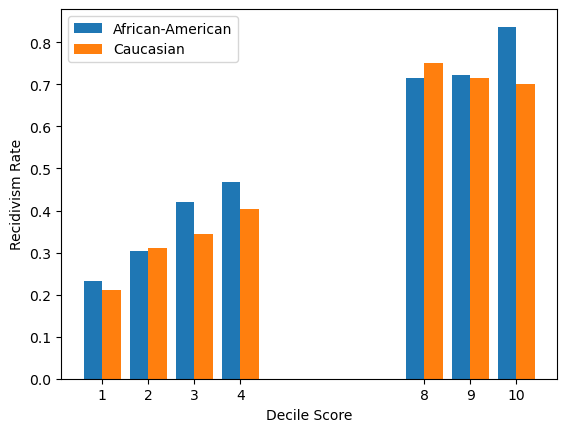

In [11]:
# evaluate calibration
# we will again use decile_score as the predicted probability of recidivism
# we will visualize the percentage of recidivism for each decile score and racial group
import matplotlib.pyplot as plt
# group by decile score and race, then calculate the average value of two_year_recid
calibration = compas_binary.groupby(['decile_score', 'race'])['two_year_recid'].mean().reset_index()
X = calibration['decile_score'].unique()
Y_AA = calibration[calibration['race'] == "African-American"]['two_year_recid']
Y_W = calibration[calibration['race'] == "Caucasian"]['two_year_recid']
# plot average recidivism rate for each decile score and the two groups
width = 0.4
plt.bar(X, Y_AA, width, label = "African-American")
plt.bar(X + width, Y_W, width, label = "Caucasian")
plt.xlabel("Decile Score")
plt.ylabel("Recidivism Rate")
plt.xticks(X + width / 2, X)
plt.legend()
plt.show()

Interestingly, we see that the average recidivism rates across different deciles are somewhat similar between the two groups. Among low-risk deciles, the model seems to underestimate the actual recidivism risks for both groups. Among high-risk deciles, it seems to overestimate the risks. Overall, we do not see a very clear pattern and in fact, this is one of COMPAS' counter-arguments to ProPublica, i.e., their risk tool is similarly calibrated for both racial groups {cite:p}`dieterich2016compas`.

## Fairness Measure for Numeric Prediction / Regression

Besides fairness measures for binary classification, we also need to consider fairness measures for numeric prediction / regression tasks, where the target variables take continuous values. A few fairness measures designed for binary classification can be generalized to the case of numeric prediction / regression. For demonstration, we will treat the ```decile_score``` as the numerical prediction values.

In [5]:
compas_regression = compas.copy()
# treating decile_score as the numerical prediction values, no need to remove any rows

### (Conditional) Demographic Parity

The same notions of demographic parity and conditional demographic parity can be defined by comparing the expected values of the predicted outcome between two groups.

```{admonition} Definition: Demographic Parity for Regression
:class: tip
$$
\mathbb{E}(\widehat{Y} | R = AA) = \mathbb{E}(\widehat{Y} | R = W)
$$
```

```{admonition} Definition: Conditional Demographic Parity for Regression
:class: tip
$$
\mathbb{E}(\widehat{Y} | R = AA, \boldsymbol{X}) = \mathbb{E}(\widehat{Y} | R = W, \boldsymbol{X})
$$
```

Detecting demographic parity can be done by essentially running a regression of $\widehat{Y}$ on $R$ (and potentially controlling for other observables to evaluate the conditional demographic parity). If $R$ is statistically significantly associated with $\widehat{Y}$, then there will be a significant difference in the expected $\widehat{Y}$ between the two groups.

In [7]:
# evaluate conditional demographic parity
# running a linear regression of decile_score on race, controlling for age, gender, number of prior offenses, and severity of charge
import statsmodels.formula.api as smf
model = smf.ols(formula = "decile_score ~ race + age + sex + priors_count + c_charge_degree", data = compas_regression).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           decile_score   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     766.5
Date:                Wed, 15 May 2024   Prob (F-statistic):               0.00
Time:                        16:38:34   Log-Likelihood:                -11558.
No. Observations:                5278   AIC:                         2.313e+04
Df Residuals:                    5272   BIC:                         2.317e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                7.7276      0.113     68.612      0.000       7.507       7.948
race[T.Caucasian]       -0.5339      0.064     -8.334      0.000      -0.660      -0.408
sex[T.Male]             -0.0735      0.076     -0.968      0.333      -0.222       0.075
c_charge_degree[T.M]    -0.4557      0.064     -7.154      0.000      -0.581      -0.331
age                     -0.1052      0.003    -39.595      0.000      -0.110      -0.100
priors_count             0.2742      0.006     42.639      0.000       0.262       0.287
==============================================================================
Omnibus:                      185.369   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.510
Skew:                           0.431   Prob(JB):                     1.92e-41
Kurtosis:                       2.667   Cond. No.                         151.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that, even after controlling for several observables, being the Caucasian is still negatively and significantly associated with risk decile.

### Residual Balance

Residual balance is analogous to the Error Balance measure in binary classification, where fairness is measured by the degree to which the model's prediction errors (which is residual in the case of regression) are balanced across the two groups. Note that we do not have the ground truth value for ```decile_score``` in the dataset. For illustration purpose only, we will use the binary label ```is_redic``` as the ground truth, and use ```decile_score``` / 10 as the predicted value.

```{admonition} Definition: Residual Balance for Regression[^footnote2]
:class: tip
$$
\mathbb{E}( (\widehat{Y} - Y)^2 | R = AA) = \mathbb{E}( (\widehat{Y} - Y)^2 | R = W)
$$
```

In [9]:
# get the residuals of the regression and store as a new column
compas_regression['residuals'] = compas_regression['decile_score'] / 10 - compas_regression['two_year_recid']
# evaluate sqaured residuals for African Americans and Caucasians
AA_residuals = compas_regression[compas_regression['race'] == 'African-American']['residuals'] ** 2
W_residuals = compas_regression[compas_regression['race'] == 'Caucasian']['residuals'] ** 2
# print results
print("Average squared residuals for African Americans: ", AA_residuals.mean())
print("Average squared residuals for Whites: ", W_residuals.mean())

Average squared residuals for African Americans:  0.2295244094488189
Average squared residuals for Whites:  0.2261388492629577


We see that African American defendents had slighter greater residuals (indicating less accurate predictions) than White defendents.

[^footnote1]: Please note that this is different from ProPublica's processing of the data; they pooled "Medium" and "High" together as "High" category.
[^footnote2]: Note that one can use other aggregation functions than $L_2$ here, such as absolute difference (i.e., $L_1$).